In [1]:
from Detector_Sensitivity_MonteCarlos import extract_data_from_file, VAtmosAbsorption, get_parameters, convert_coordinates_to_shower, read_particle_file

def get_muon_info(file_path, azimuth_rad, zenith_deg=91, all=True, particle_list=[5,6, 75, 76]): #5 and 6 are muons, 75 and 76 are muons with additional info
    pp = read_particle_file(file_path, particle_list)  # Read only specified particles
    x = [p[1] for p in pp]  # Extract x positions of muons on the ground
    y = [p[2] for p in pp ]  # Extract y positions of muons on the ground
    h = [p[3] for p in pp ]  # Extract production heights of muons if 75 or 76 else is the time since first interaction
    #t = [p[3] for p in pp if p[0] in [5, 6]]  # Extract time since first interaction for muons if 5 or 6
    E = [p[4] for p in pp ]  # Extract energies of muons on the ground
    cos_x = [p[5][0] for p in pp ] # Extract cosine of x direction of muons on the ground
    cos_y = [p[5][1] for p in pp ] # Extract cosine of y direction of muons on the ground
    cos_z = np.sqrt(1 - np.array(cos_x)**2 - np.array(cos_y)**2)
    theta_z = np.arccos(cos_z)
    theta_z_deg = np.degrees(theta_z)
    x, y, cos_x, cos_y = convert_coordinates_to_shower(np.array(x), np.array(y), np.array(cos_x), np.array(cos_y), -azimuth_rad, zenith_deg)
    try:
        if all == False:
            mask = np.array(E) == np.max(E)  # Select the muon with the highest energy
            x = np.array(x)[mask]
            y = np.array(y)[mask]
            cos_x = np.array(cos_x)[mask]
            cos_y = np.array(cos_y)[mask]
            E = np.array(E)[mask]  # Get the highest energy value
            h = np.array(h)[mask]  # Get the production height
            theta_z_deg = theta_z_deg[mask]
    except:
        x = np.array([np.nan])
        y = np.array([np.nan])
        cos_x = np.array([np.nan])
        cos_y = np.array([np.nan])
    return x, y, cos_x, cos_y, E, h, theta_z_deg

    

Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
Number of photons in event after optics only: 13590 of 70680 Ratio: 0.19227504244482174


/uufs/chpc.utah.edu/common/home/u1520754/cluster/Detector_Sensitivity_MonteCarlos.py:582: RuntimeWarning: invalid value encountered in sqrt
  z_i = np.sqrt(1 - x_i**2 - y_i**2)  # normalized z direction


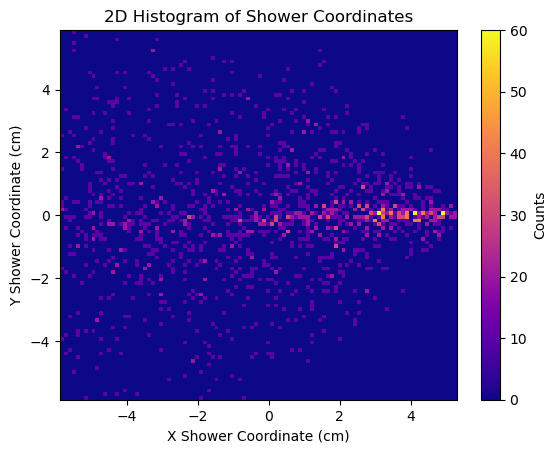

359.72867 80.709694


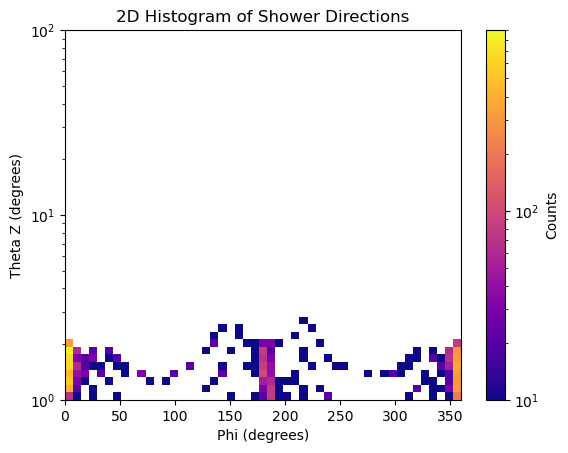

In [9]:
from Detector_Sensitivity_MonteCarlos import extract_data_from_file, VAtmosAbsorption, get_parameters, convert_coordinates_to_shower, Camera_Response
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
input_Cherenkov= "/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/20250909_apt3_condorcd/CHASM/Tilt_91.560000/diffuse_BSM_1.000_E_8.000000_Ze_45.000000_Az_0.000000_0.dat"
tele_zenith = 88
tele_azimuth = -90
atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
ran_val = random.randint(0, 1000)  # Random seed for reproducibility
atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
gen_radi = "150"
time_new, x_shower_new, y_shower_new, wavelength_new, zem_new, cos_x, cos_y, azimuth_event_degree, zenith_event_degree, x_brightest, y_brightest = extract_data_from_file(input_Cherenkov, atmos, 
                                                                                                                                R=float(gen_radi), 
                                                                                                                                filter=False, 
                                                                                                                                optics=True,
                                                                                                                                get_brightest_pixel=False,
                                                                                                                                zenith_tele=tele_zenith, 
                                                                                                                                azimuth_tele=tele_azimuth
                                                                                                                                )
remove_nan = ~np.isnan(x_shower_new) & ~np.isnan(y_shower_new)
x_shower_new = np.array(x_shower_new)[remove_nan]
y_shower_new = np.array(y_shower_new)[remove_nan]
wavelength_new = np.array(wavelength_new)[remove_nan]
T_photon = np.array(time_new)[remove_nan]
noise = True
hist, _, cam_time, _ = Camera_Response(T_photon, x_shower_new, y_shower_new, wavelength_new, noise=noise)
plt.hist2d(x_shower_new-np.mean(x_shower_new), y_shower_new-np.mean(y_shower_new), bins=100, cmap='plasma')
plt.colorbar(label='Counts')
plt.xlabel('X Shower Coordinate (cm)')
plt.ylabel('Y Shower Coordinate (cm)')
plt.title('2D Histogram of Shower Coordinates')
plt.show()
print(azimuth_event_degree, zenith_event_degree)
cos_z = np.sqrt(1 - np.array(cos_x)**2 - np.array(cos_y)**2)
theta_z = np.arccos(cos_z)
theta_z_deg = np.degrees(theta_z)[remove_nan]
phi = np.degrees(np.arctan2(cos_y, cos_x))[remove_nan]
phi = (phi + 360) % 360  # Normalize phi to [0, 360)
phi_bins = np.linspace(0, 360, 50)
theta_bins = np.logspace(0, 2, 50)
plt.hist2d(phi, theta_z_deg, bins=[phi_bins, theta_bins], cmap='plasma', norm=LogNorm())
plt.colorbar(label='Counts')
plt.yscale('log')
plt.ylabel('Theta Z (degrees)')
plt.xlabel('Phi (degrees)')
plt.title('2D Histogram of Shower Directions')
plt.show()


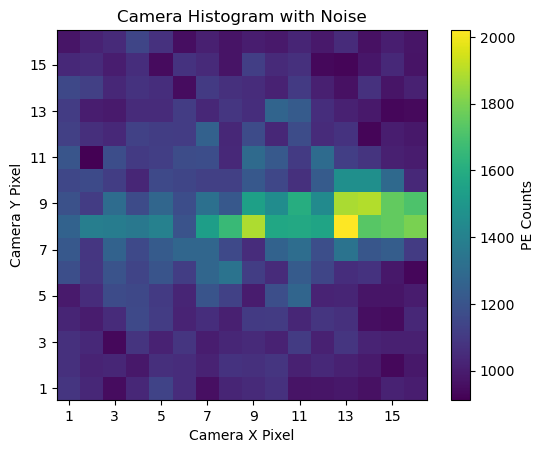

In [10]:
H = np.sum(hist[np.max(hist) >= 20], axis=1)[0]
H.shape
Cam = np.flip(H, axis=0)
plt.imshow(Cam, cmap='viridis')
plt.colorbar(label='PE Counts')
plt.xlabel('Camera X Pixel')
plt.ylabel('Camera Y Pixel')
x_ticks = range(0, 16, 2)
y_ticks = range(1, 17, 2)
x_ticks_labels = np.arange(1, 17, 2)
y_ticks_labels = np.flip(np.arange(1, 17, 2))
plt.xticks(x_ticks, x_ticks_labels)
plt.yticks(y_ticks, y_ticks_labels)
plt.title('Camera Histogram with Noise')
plt.show()

Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
277.8 89.16666
277.8 89.16666
[89.16723]


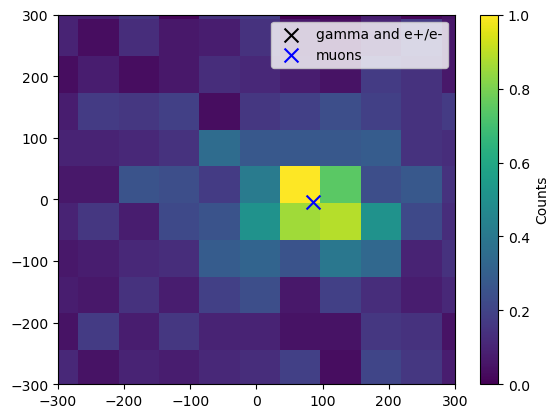

In [39]:
from Detector_Sensitivity_MonteCarlos import extract_data_from_file, VAtmosAbsorption, get_parameters, convert_coordinates_to_shower
import numpy as np
import random
import matplotlib.pyplot as plt
atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
ran_val = random.randint(0, 1000)  # Random seed for reproducibility
atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
gen_radi = "1500"
particle = 6
name_tag = "1E3_1E7"
run_tag = "6"
id = 5351-1000 #3676 713 1465 3277 3619 
input_Cherenkov = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_Demo_{name_tag}_{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
input_particle = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_Demo_{name_tag}_{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"

tele_zenith = 91
tele_azimuth = 280
time_new, x_shower_new, y_shower_new, wavelength_new, zem_new, cos_x, cos_y, azimuth_event_degree, zenith_event_degree, x_brightest, y_brightest = extract_data_from_file(input_Cherenkov, atmos, 
                                                                                                                                R=float(gen_radi), 
                                                                                                                                filter=False, 
                                                                                                                                optics=False,
                                                                                                                                get_brightest_pixel=False,
                                                                                                                                zenith_tele=tele_zenith, 
                                                                                                                                azimuth_tele=tele_azimuth
                                                                                                                                )
print(azimuth_event_degree+360, zenith_event_degree)
x_p123, y_p123, cos_x_p, cos_y_p, e_p123, t_p, theta_z_deg_p123 = get_muon_info(input_particle, np.radians(tele_azimuth), tele_zenith, all=True, particle_list=[2,3])
x_p56, y_p56, cos_x_p, cos_y_p, e_p56, t_p, theta_z_deg_p56 = get_muon_info(input_particle, np.radians(tele_azimuth), tele_zenith, all=True, particle_list=[5,6])
_,_,_,_,e_p, h_p, _ = get_muon_info(input_particle, np.radians(tele_azimuth), tele_zenith, all=True, particle_list=[75, 76])

plt.hist2d(x_shower_new, y_shower_new, bins=50, cmap='viridis')
#plt.scatter(x_shower_new, y_shower_new, s=10, c="red", marker=".", alpha=0.2, label='Cherenkov photons')
plt.scatter(x_p123, y_p123, s=100, c="black", marker="x", alpha=1, label='gamma and e+/e-')
plt.scatter(x_p56, y_p56, s=100, c="blue", marker="x", alpha=1, label='muons')
plt.ylim(-300, 300)
plt.xlim(-300, 300)
r_56 = np.sqrt(np.array(x_p56)**2 + np.array(y_p56)**2)
#print(np.array(e_p56)[r_56<=3000], np.array(h_p)[r_56<=3000])
plt.colorbar(label='Counts')
plt.legend()
#print(np.array(e_p)[r_p<=15000], np.array(h_p)[r_p<=15000])
print(azimuth_event_degree+360, zenith_event_degree)
print(theta_z_deg_p56)


In [5]:
# Define particle configurations with descriptive names
particles = {
    'muon_ground': {'list': [5, 6], 'extra': 'T'},
    'muon_source': {'list': [75, 76], 'extra': 'H'},
    'gamma': {'list': [1], 'extra': 'H'},
    'electron': {'list': [2, 3], 'extra': 'H'}  # Combined particles 2 and 3
}

# Initialize storage dictionaries
data = {key: {var: [] for var in ['X', 'Y', 'Cos_X', 'Cos_Y', 'E', particles[key]['extra'], 'Theta_Z_Deg']} 
        for key in particles}
params = {var: [] for var in ['E', 'H', 'Theta_Z_Deg', 'Weight']}

# Random sampling
ID = np.random.choice(range(5000), size=100, replace=False)

# Process each ID
for id in ID:
    input_particle = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_Demo_{name_tag}_{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"
    E_i, h_i, zenith_i, weight_i = get_parameters(f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_inputs/sampled_proton_{name_tag}_5000events.txt", id+1)
    
    try:
        # Get muon info for all particle types
        results = {}
        for key, config in particles.items():
            results[key] = get_muon_info(input_particle, np.radians(280), 91, all=True, particle_list=config['list'])
        
        # Store results
        for key, (x, y, cos_x, cos_y, e, extra, theta) in results.items():
            data[key]['X'].append(x)
            data[key]['Y'].append(y)
            data[key]['Cos_X'].append(cos_x)
            data[key]['Cos_Y'].append(cos_y)
            data[key]['E'].append(e)
            data[key][particles[key]['extra']].append(extra)
            data[key]['Theta_Z_Deg'].append(theta)
        
        # Store parameters (using muon_ground as reference for array size)
        ref_size = results['muon_ground'][4]  # e_muon_ground
        for param, value in zip(['E', 'H', 'Theta_Z_Deg', 'Weight'], [E_i, h_i, zenith_i, weight_i]):
            params[param].append(np.full_like(ref_size, value))
    except:
        continue

# Concatenate all arrays
for key in particles:
    for var in data[key]:
        data[key][var] = np.concatenate(data[key][var])

for var in params:
    params[var] = np.concatenate(params[var])

# Unpack with descriptive variable names
Xmuon_ground, Ymuon_ground, Cos_Xmuon_ground, Cos_Ymuon_ground, Emuon_ground, Tmuon_ground, Theta_Z_Degmuon_ground = \
    [data['muon_ground'][v] for v in ['X', 'Y', 'Cos_X', 'Cos_Y', 'E', 'T', 'Theta_Z_Deg']]

Xmuon_source, Ymuon_source, Cos_Xmuon_source, Cos_Ymuon_source, Emuon_source, Hmuon_source, Theta_Z_Degmuon_source = \
    [data['muon_source'][v] for v in ['X', 'Y', 'Cos_X', 'Cos_Y', 'E', 'H', 'Theta_Z_Deg']]

Xgamma, Ygamma, Cos_Xgamma, Cos_Ygamma, Egamma, Hgamma, Theta_Z_Deggamma = \
    [data['gamma'][v] for v in ['X', 'Y', 'Cos_X', 'Cos_Y', 'E', 'H', 'Theta_Z_Deg']]

Xelectron, Yelectron, Cos_Xelectron, Cos_Yelectron, Eelectron, Helectron, Theta_Z_Degelectron = \
    [data['electron'][v] for v in ['X', 'Y', 'Cos_X', 'Cos_Y', 'E', 'H', 'Theta_Z_Deg']]

E_mceq, H, Theta_Z_Deg, Weight = [params[v] for v in ['E', 'H', 'Theta_Z_Deg', 'Weight']]

# Calculate derived values
Rgamma = np.sqrt(Xgamma**2 + Ygamma**2)
Relectron = np.sqrt(Xelectron**2 + Yelectron**2)
Rmuon_source = np.sqrt(Xmuon_source**2 + Ymuon_source**2)
Rmuon_ground = np.sqrt(Xmuon_ground**2 + Ymuon_ground**2)
Delta_R = Rmuon_source - Rmuon_ground
P = np.sqrt(Delta_R**2 + Hmuon_source**2)


/tmp/ipykernel_65592/738082635.py:12: RuntimeWarning: invalid value encountered in sqrt
  cos_z = np.sqrt(1 - np.array(cos_x)**2 - np.array(cos_y)**2)


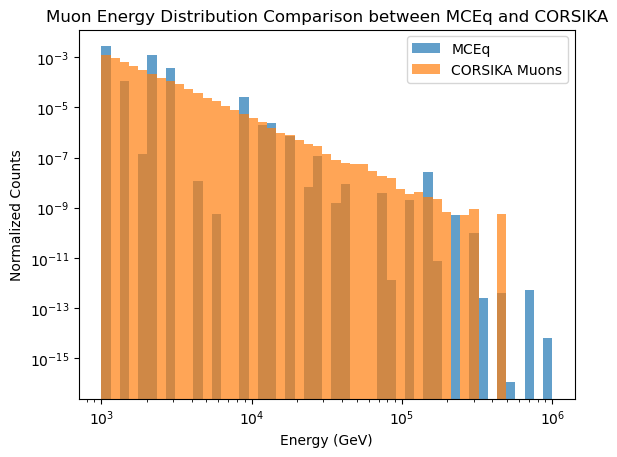

In [6]:
E_bins = np.logspace(3, 6, 50)
plt.hist(E_mceq, bins=E_bins, log=True, weights=Weight, density=True, label="MCEq", alpha=0.7)
plt.hist(E6, bins=E_bins, log=True, density=True, label="CORSIKA Muons", alpha=0.7)
plt.xlabel("Energy (GeV)")
plt.ylabel("Normalized Counts")
plt.xscale('log')
plt.legend()
#plt.xlim(1e3,1.5e5)
#plt.ylim(1e-9, 1e-3)
plt.title("Muon Energy Distribution Comparison between MCEq and CORSIKA")
plt.show()

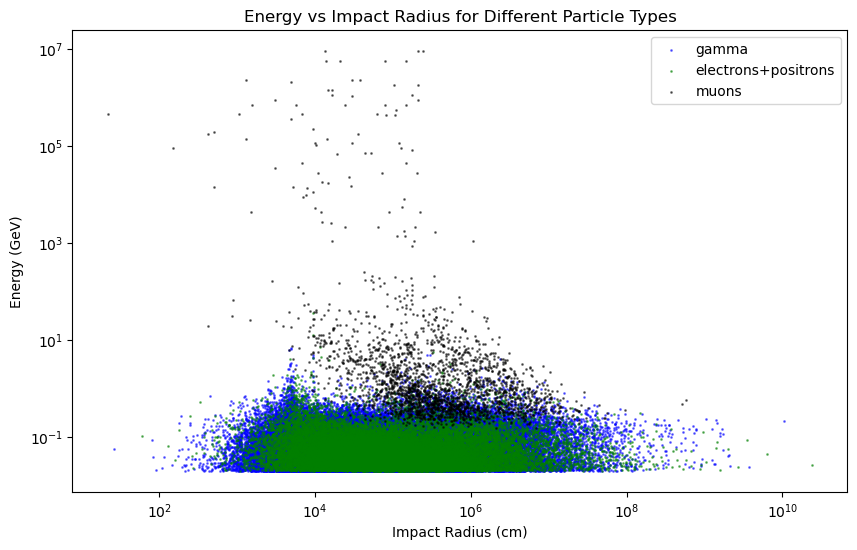

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(Rgamma, Egamma, s=1, c='b', alpha=0.5, label='gamma')
plt.scatter(Relectron, Eelectron, s=1, c='g', alpha=0.5, label='electrons+positrons')
plt.scatter(Rmuon_ground, Emuon_ground, s=1, c='k', alpha=0.5, label='muons')
plt.xlabel('Impact Radius (cm)')
plt.ylabel('Energy (GeV)')
plt.xscale('log')
plt.yscale('log')
plt.title('Energy vs Impact Radius for Different Particle Types')
plt.legend()
#plt.xlim(10, 300)
plt.show()


Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat


/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/run_header.py:82: UserWarning: Version unknown, using run header definition dtype of version 7.x
  warnings.warn("Version unknown, using run header definition dtype of version 7.x")
/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/event_header.py:138: UserWarning: Version unknown, using event header dtype definition of version 7.7XXX
  warnings.warn("Version unknown, using event header dtype definition of version 7.7XXX")


281.618 88.30899


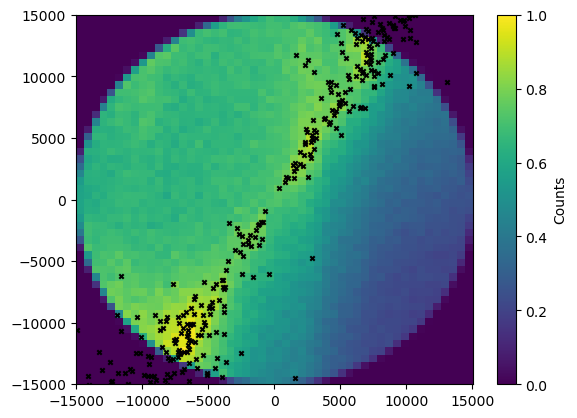

In [1]:
from Detector_Sensitivity_MonteCarlos import extract_data_from_file, VAtmosAbsorption, read_particle_file, convert_coordinates_to_shower
import numpy as np
import random
import matplotlib.pyplot as plt
atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
ran_val = random.randint(0, 1000)  # Random seed for reproducibility
atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
gen_radi = "15000"
particle = 14
name_tag = "MC_proton"
run_tag = ""
id = 1 #4997 1159 1035 4879 4631 799 1831 1073 958 1599 1992 4557 1871 1105 4829 1637 4219 4599 1914 4475
input_Cherenkov = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_{name_tag}{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
input_particle = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_{name_tag}{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"


time_new, x_shower_new, y_shower_new, wavelength_new, zem_new, cos_x, cos_y, azimuth_event_degree, zenith_event_degree, x_brightest, y_brightest = extract_data_from_file(input_Cherenkov, atmos, 
                                                                                                                                R=float(gen_radi), 
                                                                                                                                filter=False, 
                                                                                                                                optics=False,
                                                                                                                                get_brightest_pixel=False,
                                                                                                                                zenith_tele=91, 
                                                                                                                                azimuth_tele=280
                                                                                                                                )

def get_muon_info(file_path, azimuth_rad, zenith_deg=91, all=True, particle_list=[5,6, 75, 76]): #5 and 6 are muons, 75 and 76 are muons with additional info
    pp = read_particle_file(file_path, particle_list)  # Read only specified particles
    x = [p[1] for p in pp]  # Extract x positions of muons on the ground
    y = [p[2] for p in pp ]  # Extract y positions of muons on the ground
    h = [p[3] for p in pp ]  # Extract production heights of muons if 75 or 76 else is the time since first interaction
    #t = [p[3] for p in pp if p[0] in [5, 6]]  # Extract time since first interaction for muons if 5 or 6
    E = [p[4] for p in pp ]  # Extract energies of muons on the ground
    cos_x = [p[5][0] for p in pp ] # Extract cosine of x direction of muons on the ground
    cos_y = [p[5][1] for p in pp ] # Extract cosine of y direction of muons on the ground
    cos_z = np.sqrt(1 - np.array(cos_x)**2 - np.array(cos_y)**2)
    theta_z = np.arccos(cos_z)
    theta_z_deg = np.degrees(theta_z)
    x, y, cos_x, cos_y = convert_coordinates_to_shower(np.array(x), np.array(y), np.array(cos_x), np.array(cos_y), -azimuth_rad, zenith_deg)
    try:
        if all == False:
            mask = np.array(E) == np.max(E)  # Select the muon with the highest energy
            x = np.array(x)[mask]
            y = np.array(y)[mask]
            cos_x = np.array(cos_x)[mask]
            cos_y = np.array(cos_y)[mask]
            E = np.array(E)[mask]  # Get the highest energy value
            h = np.array(h)[mask]  # Get the production height
            theta_z_deg = theta_z_deg[mask]
    except:
        x = np.array([np.nan])
        y = np.array([np.nan])
        cos_x = np.array([np.nan])
        cos_y = np.array([np.nan])
    return x, y, cos_x, cos_y, E, h, theta_z_deg

    
x_p, y_p, cos_x_p, cos_y_p, e_p, t_p, theta_z_deg_p = get_muon_info(input_particle, np.radians(280), 91, all=True, particle_list=[5, 6])
_,_,_,_,_, h_p, _ = get_muon_info(input_particle, np.radians(280), 91, all=True, particle_list=[75, 76])

plt.hist2d(x_shower_new, y_shower_new, bins=50, cmap='viridis')
#plt.scatter(x_shower_new, y_shower_new, s=1, c="red", marker=".", alpha=0.3, label='Cherenkov photons')
plt.scatter(x_p, y_p, s=10, c="black", marker="x", alpha=1, label='particles')
plt.colorbar(label='Counts')
#r_p = np.sqrt(x_p**2 + y_p**2)
#print(np.array(e_p)[r_p<=15000], np.array(h_p)[r_p<=15000])
print(azimuth_event_degree+360, zenith_event_degree)


In [2]:
X6, Y6, Cos_X6, Cos_Y6, E6, T6, Theta_Z_Deg6 = [], [], [], [], [], [], []
X76, Y76, Cos_X76, Cos_Y76, E76, H76, Theta_Z_Deg76 = [], [], [], [], [], [], []
for id in range(1,11): #range(9000, 9010):
    input_particle = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_{name_tag}{run_tag}/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"
    x6, y6, cos_x6, cos_y6, e6, t6, theta_z_deg6 = get_muon_info(input_particle,np.radians(0), 0, all=True, particle_list=[5,6]) #t is time since first interaction
    x76, y76, cos_x76, cos_y76, e76, h76, theta_z_deg76 = get_muon_info(input_particle,np.radians(0), 0, all=True, particle_list=[75,76]) #h is production height
    X6.append(x6)
    Y6.append(y6)
    Cos_X6.append(cos_x6)
    Cos_Y6.append(cos_y6)
    E6.append(e6)
    T6.append(t6)
    Theta_Z_Deg6.append(theta_z_deg6)
    X76.append(x76)
    Y76.append(y76)
    Cos_X76.append(cos_x76)
    Cos_Y76.append(cos_y76)
    E76.append(e76)
    H76.append(h76)
    Theta_Z_Deg76.append(theta_z_deg76)
X6 = np.concatenate(X6)
Y6 = np.concatenate(Y6)
Cos_X6 = np.concatenate(Cos_X6)
Cos_Y6 = np.concatenate(Cos_Y6)
E6 = np.concatenate(E6)
T6 = np.concatenate(T6)
Theta_Z_Deg6 = np.concatenate(Theta_Z_Deg6)
X76 = np.concatenate(X76)
Y76 = np.concatenate(Y76)
Cos_X76 = np.concatenate(Cos_X76)
Cos_Y76 = np.concatenate(Cos_Y76)
E76 = np.concatenate(E76)
H76 = np.concatenate(H76)
Theta_Z_Deg76 = np.concatenate(Theta_Z_Deg76)
R76 = np.sqrt(X76**2 + Y76**2)
R6 = np.sqrt(X6**2 + Y6**2)
Delta_R = R76 - R6
#Path length
P = np.sqrt(Delta_R**2 + (H76)**2)


/tmp/ipykernel_86024/3218129723.py:35: RuntimeWarning: invalid value encountered in sqrt
  cos_z = np.sqrt(1 - np.array(cos_x)**2 - np.array(cos_y)**2)
/uufs/chpc.utah.edu/common/home/u1520754/cluster/Detector_Sensitivity_MonteCarlos.py:582: RuntimeWarning: invalid value encountered in sqrt
  z_i = np.sqrt(1 - x_i**2 - y_i**2)  # normalized z direction


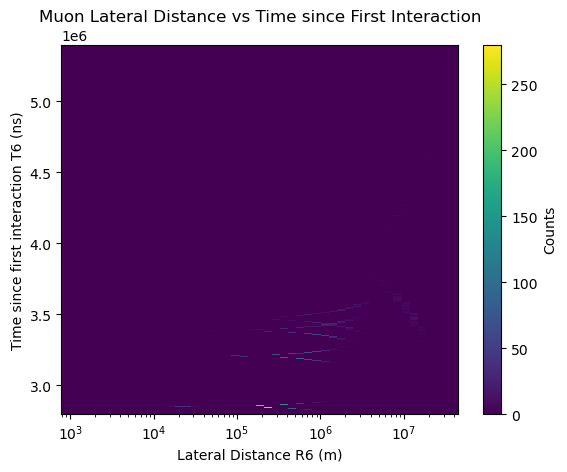

In [5]:
R_bins = np.logspace(min(np.log10(R6)), max(np.log10(R6)), num=50)
plt.hist2d(R6, T6, bins=[R_bins, 6886], cmap='viridis')
plt.colorbar(label='Counts')
plt.xscale('log')
plt.xlabel('Lateral Distance R6 (m)')
plt.ylabel('Time since first interaction T6 (ns)')
plt.title('Muon Lateral Distance vs Time since First Interaction')
plt.show()

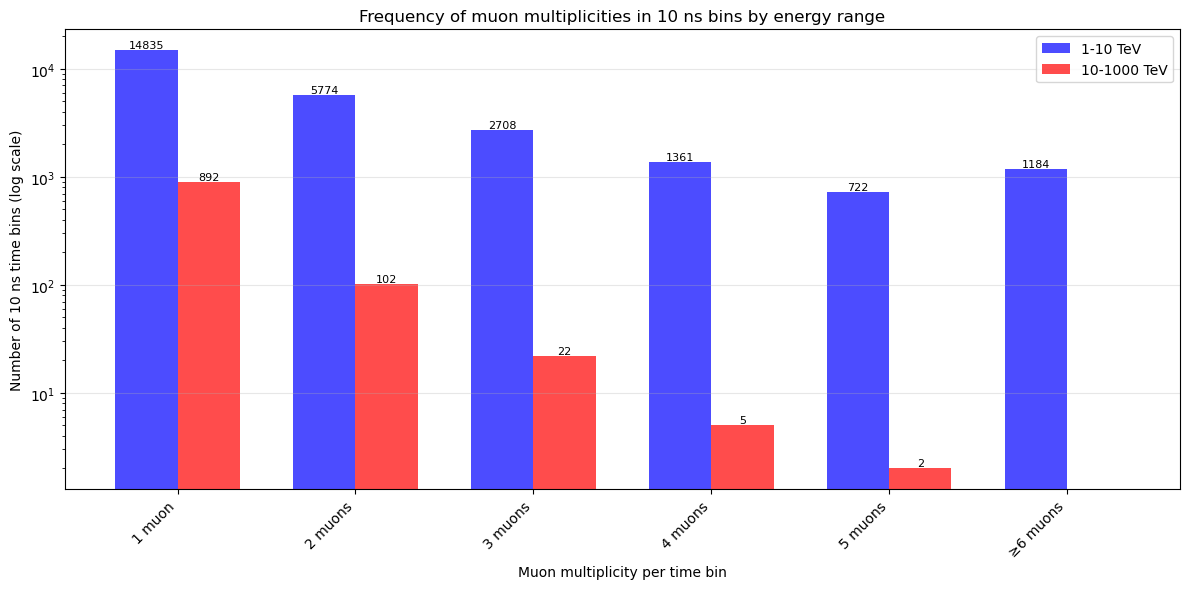

ENERGY RANGE: 1 - 10 TeV
Total muons in range: 52372
Total time bins: 260501
Time span: 2605018.50 ns

All bins (including empty):
  Bins with 0 muons: 233917 (89.8%)
  Bins with ≥1 muon: 26584 (10.2%)

Bins with at least 1 muon (N=26584):
  Bins with 1 muon: 14835 (55.8%)
  Bins with 2 muons: 5774 (21.7%)
  Bins with 3 muons: 2708 (10.2%)
  Bins with 4 muons: 1361 (5.1%)
  Bins with 5 muons: 722 (2.7%)
  Bins with ≥6 muons: 1184 (4.5%)

ENERGY RANGE: 10 - 1000 TeV
Total muons in range: 1192
Total time bins: 260501
Time span: 2605018.50 ns

All bins (including empty):
  Bins with 0 muons: 259478 (99.6%)
  Bins with ≥1 muon: 1023 (0.4%)

Bins with at least 1 muon (N=1023):
  Bins with 1 muon: 892 (87.2%)
  Bins with 2 muons: 102 (10.0%)
  Bins with 3 muons: 22 (2.2%)
  Bins with 4 muons: 5 (0.5%)
  Bins with 5 muons: 2 (0.2%)
  Bins with ≥6 muons: 0 (0.0%)


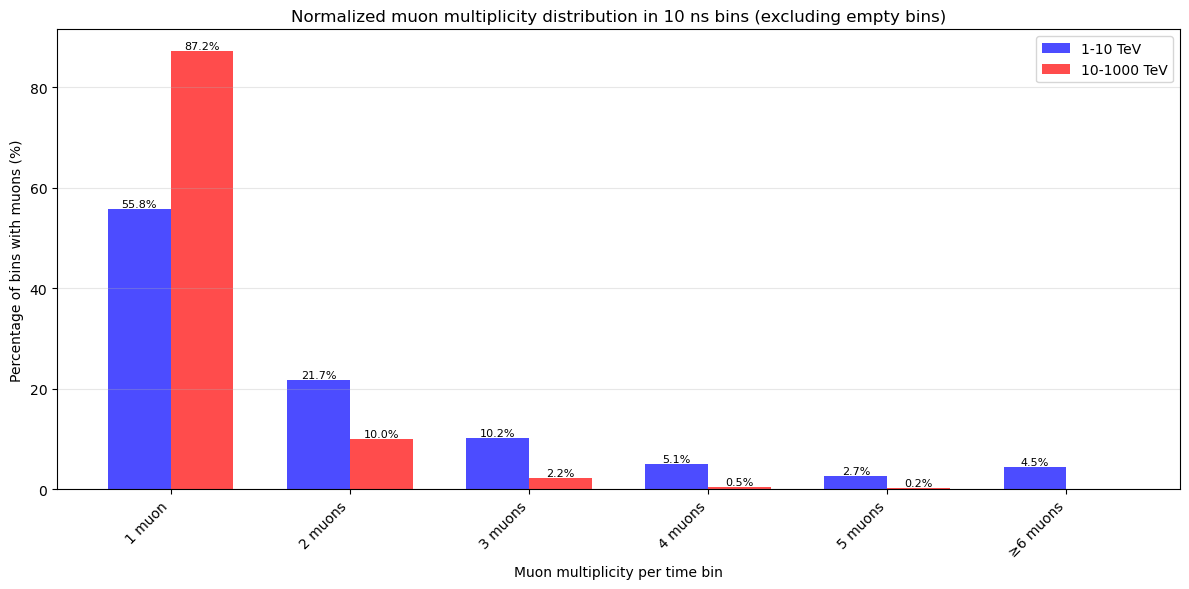

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define time parameters
Del_T = T6.max() - T6.min()  # Total time span in ns
dt = 10  # Time bin width in ns 
N_T = int(Del_T / dt)  # Number of time bins

# Define the two energy ranges
E_range_low = (1e3, 1e4)   # 1 TeV to 10 TeV
E_range_high = (1e4, 1e6)  # 10 TeV to 100 TeV

# Filter muons by energy range
mask_low = (E6 >= E_range_low[0]) & (E6 < E_range_low[1])
mask_high = (E6 >= E_range_high[0]) & (E6 < E_range_high[1])

T6_low = T6[mask_low]
E6_low = E6[mask_low]
T6_high = T6[mask_high]
E6_high = E6[mask_high]

# Create time bins
t_edges = np.linspace(T6.min(), T6.max(), N_T + 1)

# Create 1D histograms for each energy range
h_low, _ = np.histogram(T6_low, bins=t_edges)
h_high, _ = np.histogram(T6_high, bins=t_edges)

# Function to categorize bins with detailed breakdown
def categorize_bins(histogram):
    bins_0 = np.sum(histogram == 0)
    bins_1 = np.sum(histogram == 1)
    bins_2 = np.sum(histogram == 2)
    bins_3 = np.sum(histogram == 3)
    bins_4 = np.sum(histogram == 4)
    bins_5 = np.sum(histogram == 5)
    bins_6plus = np.sum(histogram >= 6)
    bins_with_muons = N_T - bins_0
    return bins_0, bins_1, bins_2, bins_3, bins_4, bins_5, bins_6plus, bins_with_muons

# Categorize for both energy ranges
bins_0_low, bins_1_low, bins_2_low, bins_3_low, bins_4_low, bins_5_low, bins_6plus_low, bins_with_muons_low = categorize_bins(h_low)
bins_0_high, bins_1_high, bins_2_high, bins_3_high, bins_4_high, bins_5_high, bins_6plus_high, bins_with_muons_high = categorize_bins(h_high)

# Plot overlapping histograms
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['1 muon', '2 muons', '3 muons', '4 muons', '5 muons', '≥6 muons']
frequencies_low = [bins_1_low, bins_2_low, bins_3_low, bins_4_low, bins_5_low, bins_6plus_low]
frequencies_high = [bins_1_high, bins_2_high, bins_3_high, bins_4_high, bins_5_high, bins_6plus_high]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, frequencies_low, width, 
               label=f'{E_range_low[0]/1e3:.0f}-{E_range_low[1]/1e3:.0f} TeV',
               color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, frequencies_high, width,
               label=f'{E_range_high[0]/1e3:.0f}-{E_range_high[1]/1e3:.0f} TeV',
               color='red', alpha=0.7)

ax.set_yscale('log')
ax.set_ylabel(f'Number of {dt} ns time bins (log scale)')
ax.set_xlabel('Muon multiplicity per time bin')
ax.set_title(f'Frequency of muon multiplicities in {dt} ns bins by energy range')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics for LOW energy range
print(f"="*60)
print(f"ENERGY RANGE: {E_range_low[0]/1e3:.0f} - {E_range_low[1]/1e3:.0f} TeV")
print(f"="*60)
print(f"Total muons in range: {len(T6_low)}")
print(f"Total time bins: {N_T}")
print(f"Time span: {Del_T:.2f} ns")
print(f"\nAll bins (including empty):")
print(f"  Bins with 0 muons: {bins_0_low} ({100*bins_0_low/N_T:.1f}%)")
print(f"  Bins with ≥1 muon: {bins_with_muons_low} ({100*bins_with_muons_low/N_T:.1f}%)")

if bins_with_muons_low > 0:
    print(f"\nBins with at least 1 muon (N={bins_with_muons_low}):")
    print(f"  Bins with 1 muon: {bins_1_low} ({100*bins_1_low/bins_with_muons_low:.1f}%)")
    print(f"  Bins with 2 muons: {bins_2_low} ({100*bins_2_low/bins_with_muons_low:.1f}%)")
    print(f"  Bins with 3 muons: {bins_3_low} ({100*bins_3_low/bins_with_muons_low:.1f}%)")
    print(f"  Bins with 4 muons: {bins_4_low} ({100*bins_4_low/bins_with_muons_low:.1f}%)")
    print(f"  Bins with 5 muons: {bins_5_low} ({100*bins_5_low/bins_with_muons_low:.1f}%)")
    print(f"  Bins with ≥6 muons: {bins_6plus_low} ({100*bins_6plus_low/bins_with_muons_low:.1f}%)")

# Print summary statistics for HIGH energy range
print(f"\n{'='*60}")
print(f"ENERGY RANGE: {E_range_high[0]/1e3:.0f} - {E_range_high[1]/1e3:.0f} TeV")
print(f"="*60)
print(f"Total muons in range: {len(T6_high)}")
print(f"Total time bins: {N_T}")
print(f"Time span: {Del_T:.2f} ns")
print(f"\nAll bins (including empty):")
print(f"  Bins with 0 muons: {bins_0_high} ({100*bins_0_high/N_T:.1f}%)")
print(f"  Bins with ≥1 muon: {bins_with_muons_high} ({100*bins_with_muons_high/N_T:.1f}%)")

if bins_with_muons_high > 0:
    print(f"\nBins with at least 1 muon (N={bins_with_muons_high}):")
    print(f"  Bins with 1 muon: {bins_1_high} ({100*bins_1_high/bins_with_muons_high:.1f}%)")
    print(f"  Bins with 2 muons: {bins_2_high} ({100*bins_2_high/bins_with_muons_high:.1f}%)")
    print(f"  Bins with 3 muons: {bins_3_high} ({100*bins_3_high/bins_with_muons_high:.1f}%)")
    print(f"  Bins with 4 muons: {bins_4_high} ({100*bins_4_high/bins_with_muons_high:.1f}%)")
    print(f"  Bins with 5 muons: {bins_5_high} ({100*bins_5_high/bins_with_muons_high:.1f}%)")
    print(f"  Bins with ≥6 muons: {bins_6plus_high} ({100*bins_6plus_high/bins_with_muons_high:.1f}%)")

# Optional: Plot normalized comparison (percentages)
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate percentages (excluding 0 bins)
if bins_with_muons_low > 0:
    pct_low = [100*bins_1_low/bins_with_muons_low, 
               100*bins_2_low/bins_with_muons_low, 
               100*bins_3_low/bins_with_muons_low,
               100*bins_4_low/bins_with_muons_low,
               100*bins_5_low/bins_with_muons_low,
               100*bins_6plus_low/bins_with_muons_low]
else:
    pct_low = [0, 0, 0, 0, 0, 0]

if bins_with_muons_high > 0:
    pct_high = [100*bins_1_high/bins_with_muons_high, 
                100*bins_2_high/bins_with_muons_high, 
                100*bins_3_high/bins_with_muons_high,
                100*bins_4_high/bins_with_muons_high,
                100*bins_5_high/bins_with_muons_high,
                100*bins_6plus_high/bins_with_muons_high]
else:
    pct_high = [0, 0, 0, 0, 0, 0]

bars1 = ax.bar(x - width/2, pct_low, width,
               label=f'{E_range_low[0]/1e3:.0f}-{E_range_low[1]/1e3:.0f} TeV',
               color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, pct_high, width,
               label=f'{E_range_high[0]/1e3:.0f}-{E_range_high[1]/1e3:.0f} TeV',
               color='red', alpha=0.7)

ax.set_ylabel('Percentage of bins with muons (%)')
ax.set_xlabel('Muon multiplicity per time bin')
ax.set_title(f'Normalized muon multiplicity distribution in {dt} ns bins (excluding empty bins)')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


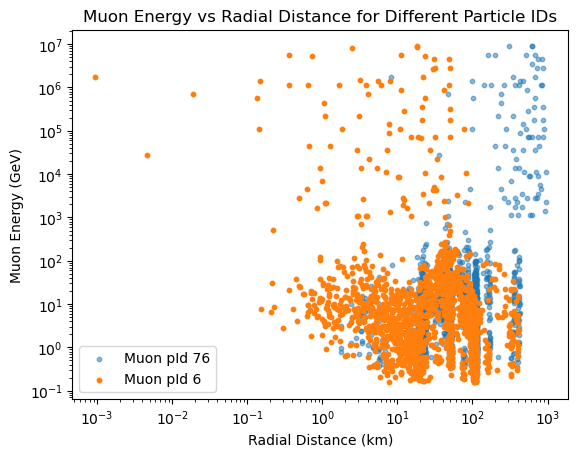

In [7]:
plt.scatter(R76/1e5, E76, s=10, alpha=0.5, label='Muon pId 76')
plt.scatter(R6/1e5, E6, s=10, label='Muon pId 6')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (km)')
plt.ylabel('Muon Energy (GeV)')
plt.legend()
plt.title('Muon Energy vs Radial Distance for Different Particle IDs')
plt.show()

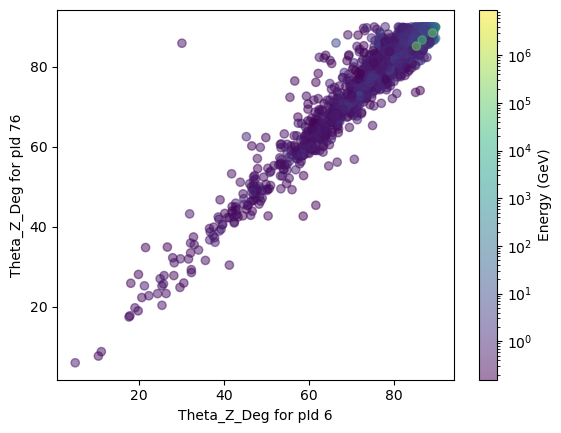

In [8]:
from matplotlib.colors import LogNorm
plt.scatter(Theta_Z_Deg6, Theta_Z_Deg76, c=E6, alpha=0.5, norm=LogNorm())
plt.xlabel("Theta_Z_Deg for pId 6")
plt.ylabel("Theta_Z_Deg for pId 76")
plt.colorbar(label='Energy (GeV)')
plt.show()